In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import importlib

for module in ['kooplearn', 'datasets', 'matplotlib', 'ml-confs']: # !! Add here any additional module that you need to install on top of kooplearn
    try:
        importlib.import_module(module)
    except ImportError:
        if module == 'kooplearn':
            module = 'kooplearn[full]'
        %pip install -q {module}

Note: you may need to restart the kernel to use updated packages.


Data already preprocessed.
train (800) example: tensor([0, 1, 2, 3, 4])
test (1001) example: tensor([0, 1, 2, 3, 4])
validation (201) example: tensor([0, 1, 2, 3, 4])


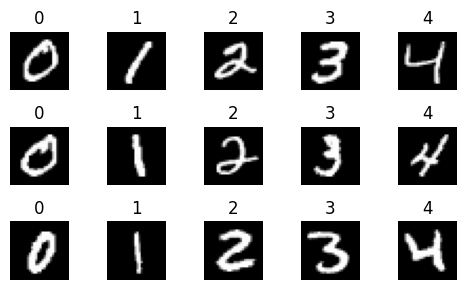

In [3]:
import data_pipeline
import ml_confs
from datasets import load_from_disk
import matplotlib.pyplot as plt

data_pipeline.main() # Run data download and preprocessing
configs = ml_confs.from_file('configs.yaml') # Load configs
ordered_MNIST = load_from_disk('__data__') # Load dataset (torch)
np_ordered_MNIST = ordered_MNIST.with_format(type='numpy', columns=['image', 'label']) # Copy of the dataset in numpy format

fig, ax = plt.subplots(3, configs.classes, figsize=(configs.classes, 3))
for j, split in enumerate(['train', 'test', 'validation']):
    print(f'{split} ({len(ordered_MNIST[split])}) example: {ordered_MNIST[split]["label"][:configs.classes]}')
    for i in range(configs.classes):
        data = ordered_MNIST['train'][configs.classes*j + i]
        ax[j, i].imshow(data['image'], cmap='gray')
        ax[j, i].set_title(data['label'].item())
        ax[j, i].axis('off')
fig.tight_layout()

## Setting up a validation scheme
The validation of each model will be performed as follows: starting from a test image of the digit $c$, we will predict the next image by calling `model.predict`. The prediction should be an MNIST-alike image of the digit $c+1$ (modulo `configs.classes`). We will feed this prediction to a very strong MNIST classifier, and evaluate how its accuracy degrades over time.

### Defining the _oracle_ classifier

In [4]:
import torch.nn as nn
import torch

#Setting up the architecture
class CNNEncoder(nn.Module):
    def __init__(self, num_classes):
        super(CNNEncoder, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # Fully connected layer, output num_classes classes
        self.out = nn.Sequential(
            nn.Linear(32 * 7 * 7, num_classes)
        )  
        torch.nn.init.orthogonal_(self.out[0].weight)      
    
    def forward(self, X):
        if X.dim() == 3:
            X = X.unsqueeze(1) # Add a channel dimension if needed
        X = self.conv1(X)
        X = self.conv2(X)
        # Flatten the output of conv2
        X = X.view(X.size(0), -1)       
        output = self.out(X)
        return output

We wrap the oracle classifier around a `kooplearn.abc.TrainableFeatureMap`. This will allow us to easily replicate the setting of Kostic et al. 2022, and it is pedagogical to show how `kooplearn` can be extended.

In [5]:
from kooplearn.abc import TrainableFeatureMap

import os
from typing import Optional, NamedTuple
import logging

import lightning
import numpy as np

class Metrics(NamedTuple):
    train_acc: list[float]
    train_steps: list[float]
    val_acc: list[float]
    val_steps: list[float]


#Following kooplearn implementations, we define a Pytorch Lightning module and then wrap it in a TrainableFeatureMap
class ClassifierModule(lightning.LightningModule):
    def __init__(self, num_classes: int, learning_rate: float):
        super().__init__()
        self.num_classes = num_classes
        self.encoder = CNNEncoder(num_classes=num_classes)
        self.learning_rate = learning_rate
        self.loss_fn = torch.nn.CrossEntropyLoss()
    
    def on_fit_start(self):
        self.metrics = Metrics([], [], [], [])

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr = self.learning_rate)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        images, labels = batch['image'], batch['label']
        output = self.encoder(images)               
        loss = self.loss_fn(output, labels)
        with torch.no_grad():
            pred_labels = output.argmax(dim=1)
            accuracy = (pred_labels == labels).float().mean()
        
        #Log metrics
        self.metrics.train_acc.append(accuracy.item())
        self.metrics.train_steps.append(self.global_step)
        
        return {'loss': loss, 'train/accuracy': accuracy}
    
    def validation_step(self, batch, batch_idx):
        images, labels = batch['image'], batch['label']
        output = self.encoder(images)  
        pred_labels = output.argmax(dim=1)
        accuracy = (pred_labels == labels).float().mean() # Scalar

        self.metrics.val_acc.append(accuracy.item())
        self.metrics.val_steps.append(self.global_step)

        return {'val/accuracy': accuracy}
    
class ClassifierFeatureMap(TrainableFeatureMap):
    def __init__(
                self, 
                num_classes: int,
                learning_rate: float,
                trainer: lightning.Trainer,
                seed: Optional[int] = None  
                ):
        #Set rng seed
        lightning.seed_everything(seed)
        self.seed = seed
        self.lightning_module = ClassifierModule(num_classes, learning_rate)
        
        #Init trainer
        self.lightning_trainer = trainer
        self._is_fitted = False
        
    @property
    def is_fitted(self) -> bool:
        return self._is_fitted
    
    @property
    def lookback_len(self) -> int:
        return 1 #Hardcoding it here, as we are not using lookback windows
    
    #Not tested
    def save(self, path: os.PathLike):
        raise NotImplementedError
    
    #Not tested
    @classmethod
    def load(cls, path: os.PathLike):
       raise NotImplementedError

    def fit(self, **trainer_fit_kwargs: dict):
        if 'model' in trainer_fit_kwargs:
            logging.warn(f"The 'model' keyword should not be specified in trainer_fit_kwargs. The provided model '{trainer_fit_kwargs['model']}' is ignored.")
            trainer_fit_kwargs = trainer_fit_kwargs.copy()
            del trainer_fit_kwargs['model']
        self.lightning_trainer.fit(model=self.lightning_module, **trainer_fit_kwargs)
        self._is_fitted = True

    def __call__(self, X: np.ndarray) -> np.ndarray:
        X = torch.from_numpy(X.copy(order="C")).float()
        self.lightning_module.eval()
        with torch.no_grad():
            embedded_X = self.lightning_module.encoder(
                X.to(self.lightning_module.device)
            )
            embedded_X = embedded_X.detach().cpu().numpy()
        return embedded_X

Let's train `ClassifierFeatureMap` on our `ordered_MNIST` dataset

In [6]:
from torch.utils.data import DataLoader
oracle_train_dl = DataLoader(ordered_MNIST['train'], batch_size=configs.batch_size, shuffle=True)
oracle_val_dl = DataLoader(ordered_MNIST['validation'], batch_size=len(ordered_MNIST['validation']), shuffle=False)
        
trainer_kwargs = {
    'accelerator': 'gpu',
    'max_epochs': 20,
    'log_every_n_steps': 2,
    'enable_progress_bar': False,
    'devices': 1
}

trainer = lightning.Trainer(**trainer_kwargs)

oracle = ClassifierFeatureMap(
    configs.classes,
    1e-2,
    trainer, 
    seed=configs.rng_seed
)

oracle.fit(train_dataloaders=oracle_train_dl, val_dataloaders=oracle_val_dl)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type             | Params
---------------------------------------------
0 | encoder | CNNEncoder       | 21.1 K
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
21.1 K    Trainable params
0         Non-trainable params
21.1 K    Total params
0.084     Total estimated model params size (MB)
/home/novelli/anaconda3/envs/kooplearn/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/novelli/anaconda3/

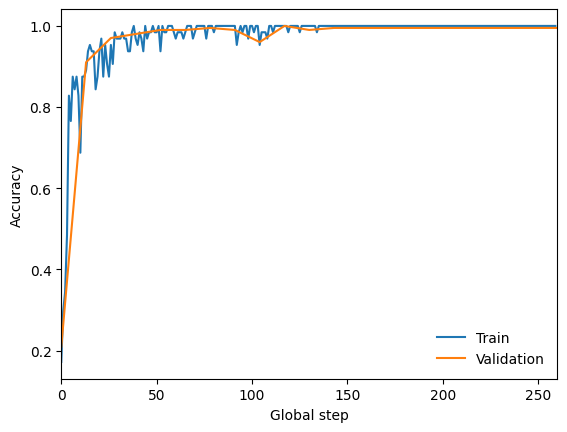

In [7]:
fig, ax = plt.subplots(1, 1)
ax.plot(oracle.lightning_module.metrics.train_steps, oracle.lightning_module.metrics.train_acc, label='Train')
ax.plot(oracle.lightning_module.metrics.val_steps, oracle.lightning_module.metrics.val_acc, label='Validation')
ax.set_xlabel('Global step')
ax.set_ylabel('Accuracy')
ax.legend(frameon=False, loc='lower right')
ax.margins(x=0)

# Model fitting

In [8]:
from kooplearn.models import DMD, DeepEDMD
from kooplearn.models.feature_maps.nn import NNFeatureMap
from kooplearn.data import traj_to_contexts

train_data = traj_to_contexts(ordered_MNIST['train']['image'], backend='numpy')
val_data = traj_to_contexts(ordered_MNIST['validation']['image'], backend='numpy')
test_data = traj_to_contexts(ordered_MNIST['test']['image'], backend='numpy')
test_labels = np.take(ordered_MNIST['test']['label'], np.squeeze(test_data.idx_map.lookback(1))).detach().cpu().numpy()
transfer_operator_models = {}

### Linear Ridge Regression

In [9]:
linear_model = DMD(reduced_rank = configs.reduced_rank, rank=configs.classes).fit(train_data)
transfer_operator_models['Linear'] = linear_model

### Classifier features (as in Sec. 6 of Kostic et al. 2022)

In [10]:
classifier_model = DeepEDMD(oracle, reduced_rank=False, rank=configs.classes).fit(train_data)
transfer_operator_models['Classifier_Baseline'] = classifier_model

## Dataloader for `kooplearn`

In [11]:
from kooplearn.nn.data import collate_context_dataset

train_dl = DataLoader(train_data, batch_size = configs.batch_size, shuffle=True, collate_fn=collate_context_dataset)

### DPNets

In [12]:
from kooplearn.nn import DPLoss, VAMPLoss
trainer_kwargs = {
    'accelerator': 'gpu',
    'devices': 1,
    'max_epochs': configs.max_epochs,  
    'log_every_n_steps': 3,
    'enable_model_summary': False
}


feature_maps = {
    'DPNets_Relaxed': {
        'loss_fn': DPLoss,
        'loss_kwargs': {'relaxed': True, 'metric_deformation': 1, 'center_covariances': False}
    },
    'DPNets': {
        'loss_fn': DPLoss,
        'loss_kwargs': {'relaxed': False, 'metric_deformation': 1, 'center_covariances': False}
    },
    'VAMPNets': {
        'loss_fn': VAMPLoss,
        'loss_kwargs': {'schatten_norm': 2, 'center_covariances': False}
    },
}

for fname, fdict in feature_maps.items():
    print(f"Fitting {fname.replace('_', ' ')}")
    trainer = lightning.Trainer(**trainer_kwargs)
    #Defining the model
    feature_map = NNFeatureMap(
        CNNEncoder,
        fdict['loss_fn'],
        torch.optim.Adam,
        trainer,
        encoder_kwargs={'num_classes': configs.classes},
        loss_kwargs=fdict['loss_kwargs'],
        optimizer_kwargs={'lr': 9e-4},
        seed=configs.rng_seed
    )
    feature_map.fit(train_dl)
    nn_model = DeepEDMD(feature_map, reduced_rank = configs.reduced_rank, rank=configs.classes).fit(train_data)
    transfer_operator_models[fname] = nn_model

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Fitting DPNets Relaxed
Fitting NNFeatureMap. Lookback window length set to 1


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Fitting DPNets
Fitting NNFeatureMap. Lookback window length set to 1


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Fitting VAMPNets
Fitting NNFeatureMap. Lookback window length set to 1


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


## Dynamic AutoEncoder

In [13]:
#A decoder which is specular to CNNEncoder, starting with a fully connected layer and then reshaping the output to a 2D image
class CNNDecoder(nn.Module):
    def __init__(self, num_classes=10):
        super(CNNDecoder, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(num_classes, 32 * 7 * 7)
        )
        
        self.conv1 = nn.Sequential(  
            nn.Upsample(scale_factor=2),
            nn.ReLU(),   
            nn.ConvTranspose2d(
                in_channels=32,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            )                            
        )
        self.conv2 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ReLU(),                               
            nn.ConvTranspose2d(16, 1, 5, 1, 2)                
        )
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), 32, 7, 7)
        x = self.conv1(x)
        x = self.conv2(x)
        #Remove the channel dimension
        x = x.squeeze(1)
        return x

In [14]:
from kooplearn.models import DynamicAE
from lightning.pytorch.callbacks import LearningRateFinder
lr_finder = LearningRateFinder(min_lr=1e-6, max_lr=1e-2, early_stop_threshold=None)

trainer_kwargs = {
    'accelerator': 'gpu',
    'devices': 1,
    'max_epochs': configs.max_epochs + 200,  
    'log_every_n_steps': 3,
    # 'callbacks': [lr_finder],
}
trainer = lightning.Trainer(**trainer_kwargs)

dae = DynamicAE(
    encoder=CNNEncoder,
    decoder=CNNDecoder,
    latent_dim=configs.classes,
    optimizer_fn=torch.optim.Adam,
    optimizer_kwargs={'lr': 9e-4},
    trainer=trainer,
    loss_weights= {"rec": 1.0, "pred": 1.0, "lin": 1.0},
    encoder_kwargs={'num_classes': configs.classes},
    decoder_kwargs={'num_classes': configs.classes},
    seed=configs.rng_seed)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 0


In [15]:
dae.fit(train_dataloaders=train_dl)
transfer_operator_models["Dynamical_AE"] = dae

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | CNNEncoder | 21.1 K
1 | decoder | CNNDecoder | 22.6 K
2 | _lin    | Linear     | 25    
---------------------------------------
43.7 K    Trainable params
0         Non-trainable params
43.7 K    Total params
0.175     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=210` reached.


## Consistent AutoEncoder

In [16]:
from kooplearn.models import ConsistentAE

trainer_kwargs = {
    'accelerator': 'gpu',
    'devices': 1,
    'max_epochs': configs.max_epochs + 200,  
    'log_every_n_steps': 3,
    # 'callbacks': [lr_finder],
}
trainer = lightning.Trainer(**trainer_kwargs)

cae = ConsistentAE(
    encoder=CNNEncoder,
    decoder=CNNDecoder,
    latent_dim=configs.classes,
    optimizer_fn=torch.optim.Adam,
    optimizer_kwargs={'lr': 9e-4},
    trainer=trainer,
    loss_weights= {
        "rec": 1.0,
        "pred": 1.0,
        "bwd_pred": 1.0,
        "lin": 1.0,
        "consistency": 1.0,
    },
    encoder_kwargs={'num_classes': configs.classes},
    decoder_kwargs={'num_classes': configs.classes},
    seed=configs.rng_seed)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 0


In [17]:
cae.fit(train_dataloaders=train_dl)
transfer_operator_models["Consistent_AE"] = cae

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | CNNEncoder | 21.1 K
1 | decoder  | CNNDecoder | 22.6 K
2 | _lin     | Linear     | 25    
3 | _bwd_lin | Linear     | 25    
----------------------------------------
43.8 K    Trainable params
0         Non-trainable params
43.8 K    Total params
0.175     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=210` reached.


# Final comparison
## Model evaluation function

In [16]:
from kooplearn.abc import BaseModel
from kooplearn.models.ae.consistent import ConsistentAE

def evaluate_model(model: BaseModel, test_data):
    assert model.is_fitted
    if isinstance(model, ConsistentAE):
        print("Triggered padding")   
        raise NotImplementedError     
        #Pad with zeros
        # padding = np.zeros_like(test_images)
        # test_images = np.concatenate([padding]*(model.lookback_len - 1)+ [test_images], axis=1)    
    print(f"Model {model.__class__.__name__}'s lookback len is {model.lookback_len}")
    print(f"Test-data {test_data.shape}")
    report = {
        'accuracy': [],
        'label': [],
        'image': [],
        'times': []
    }
    for t in range(1, configs.eval_up_to_t + 1):
        pred = model.predict(test_data, t=t) # Shape of the lookforward window
        pred_labels = oracle(pred.reshape(-1, 28,28)).argmax(axis=1)
        accuracy = (pred_labels == (test_labels + t)%configs.classes ).mean()
        report['accuracy'].append(accuracy)
        report['image'].append(pred)
        report['label'].append(pred_labels)
        report['times'].append(t)
    return report

In [17]:
report = {}
for model_name, model in transfer_operator_models.items():
    print(f"Evaluating {model_name}")
    report[model_name] = evaluate_model(model, test_data)

Evaluating Linear
Model DMD's lookback len is 1
Test-data (1000, 2, 28, 28)
Evaluating Classifier_Baseline
Model DeepEDMD's lookback len is 1
Test-data (1000, 2, 28, 28)
Evaluating DPNets_Relaxed
Model DeepEDMD's lookback len is 1
Test-data (1000, 2, 28, 28)
Evaluating DPNets
Model DeepEDMD's lookback len is 1
Test-data (1000, 2, 28, 28)
Evaluating VAMPNets
Model DeepEDMD's lookback len is 1
Test-data (1000, 2, 28, 28)
Evaluating Dynamical_AE
Model DynamicAE's lookback len is 1
Test-data (1000, 2, 28, 28)


AttributeError: 'numpy.ndarray' object has no attribute 'dim'

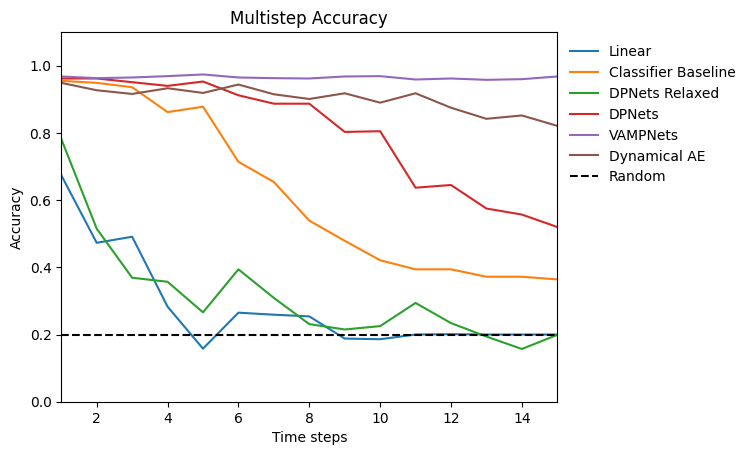

In [20]:
fig, ax = plt.subplots()
for model_name in report.keys():
    t = report[model_name]['times']
    acc = report[model_name]['accuracy']
    
    ax.plot(t, acc, label=model_name.replace('_', ' '))

ax.axhline(1/configs.classes, color='black', linestyle='--', label='Random')

ax.legend(frameon=False, bbox_to_anchor=(1, 1))
ax.margins(x=0)
ax.set_ylim(0, 1.1)
ax.set_xlabel('Time steps')
ax.set_ylabel('Accuracy')
ax.set_title('Multistep Accuracy')
plt.show()